# Apply the trained model

In [1]:
import os
import wget

import tensorflow as tf

import object_detection
from object_detection.builders import model_builder
from object_detection.protos   import pipeline_pb2
from object_detection.utils    import config_util
from object_detection.utils    import label_map_util
from object_detection.utils    import visualization_utils as viz_utils

from google.protobuf import text_format

import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Check whether the GPU is recognised
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Model Configuration

In [2]:
CUSTOM_MODEL_NAME = 'centernet_hg104_512x512_coco17_tpu-8'
LABEL_MAP_NAME    = 'label_map.pbtxt'

labels = [{'name':'BikeLaneMarker', 'id':1}]

input_directory = os.path.join('data_sources', 'test1')
output_directory = os.path.join('data_sources', 'test1_out')

## Model Setup

In [3]:
# Change working directory
os.chdir(os.pardir)

paths = {
    'ANNOTATION_PATH':       os.path.join('Tensorflow', 'workspace', 'annotations'),
    'IMAGE_PATH_TEST':       input_directory,
    'IMAGE_PATH_OUT':        output_directory,
    'CHECKPOINT_PATH':       os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME),
}

files = {
    'PIPELINE_CONFIG':  os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'LABELMAP':         os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

# Create directories if they do not already exist
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}      

In [4]:
# Load pipeline config and build a detection model
configs         = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Find the latest checkpoint
latest_checkpoint = 'ckpt-1'

checkpoint_files = os.listdir(paths['CHECKPOINT_PATH'])

for f in checkpoint_files:
    if f.startswith('ckpt-'):
        latest_checkpoint = f.split('.')[0]
print('Latest Checkpoint: ' + latest_checkpoint)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], latest_checkpoint)).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes   = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections      = detection_model.postprocess(prediction_dict, shapes)
    return detections

category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

Latest Checkpoint: ckpt-27


In [21]:
def apply_model(IMAGE_FILENAME, min_score=0.5, write=True, display=False, log=False, verbose=False):
    if verbose:
        print(IMAGE_FILENAME)
    
    # Define path for input inmage and output image with detections
    IMAGE_PATH  = os.path.join(paths['IMAGE_PATH_TEST'], IMAGE_FILENAME)
    OUTPUT_PATH = os.path.join(paths['IMAGE_PATH_OUT'],  IMAGE_FILENAME)

    if not os.path.exists(IMAGE_PATH):
        print(IMAGE_PATH + ' does not exist')
        return
        
    # Read the image and convert it into a tensor
    img          = cv2.imread(IMAGE_PATH)
    image_np     = np.array(img)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
              
    # Detect objects of interest using the model
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # Count detections that met the threshold
    num_detections_threshold = 0
    
    if num_detections > 0:
        for idx, score in enumerate(detections['detection_scores']):
            if score >= min_score:
                num_detections_threshold = num_detections_threshold + 1
        
    if verbose:
        print('num_detections_threshold: ' + str(num_detections_threshold))
        
        if num_detections_threshold > 0:
            for idx, score in enumerate(detections['detection_scores']):
                if score >= min_score:
                    print('Detection box:            ' + str(score) + ' ' + str(detections['detection_boxes'][idx]))
    
    if log and num_detections_threshold > 0:
        try:
            filename_split = IMAGE_FILENAME.split('_')
            node_id   = filename_split[1]
            offset_id = filename_split[2]
            heading   = filename_split[3]
            
            detection_log_path = os.path.join(paths['IMAGE_PATH_OUT'], 'detection_log.csv')
            
            if not os.path.exists(detection_log_path):
                detection_log = open(detection_log_path, 'w')
                detection_log.write('node_id,offset_id,heading,score,bbox_0,bbox_1,bbox_2,bbox_3\n')
            else:
                detection_log = open(detection_log_path, 'a')
                
            for idx, score in enumerate(detections['detection_scores']):
                if score >= min_score:
                    detection_log.write(
                        str(node_id)   + ',' +
                        str(offset_id) + ',' +
                        str(heading)   + ',' +
                        str(score)     + ',' +
                        str(detections['detection_boxes'][idx][0]) + ',' +
                        str(detections['detection_boxes'][idx][1]) + ',' +
                        str(detections['detection_boxes'][idx][2]) + ',' +
                        str(detections['detection_boxes'][idx][3]) + '\n'
                    )
            
            detection_log.close()
            
        except Exception as e:
            print('Unable to log detections for [' + IMAGE_FILENAME + ']: ' + str(sys.exc_value))
        
        
    if write or display:
        # Detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        # Create a copy of the image with detection boxes overlaid
        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=min_score,
            agnostic_mode=False
        )

        if write:
            # Write the output image to disk
            cv2.imwrite(OUTPUT_PATH, image_np_with_detections)

        if display:
            # Convert color space of the output image
            image_np_converted = cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB)

            plt.imshow(image_np_converted)
            plt.show()

## Model Application

gsv_30204323_10_177_gsv_0.jpg
num_detections_threshold: 1
Detection box:            0.73774624 [0.42896956 0.31630668 0.45366538 0.37599835]


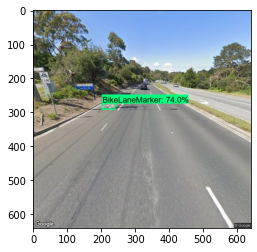

In [22]:
apply_model('gsv_30204323_10_177_gsv_0.jpg', write=False, display=True, log=True, verbose=True)

gsv_30204323_0_347_gsv_0.jpg
num_detections_threshold: 0


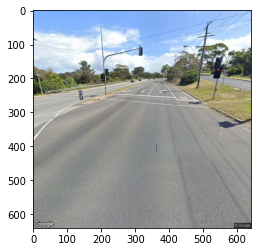

In [20]:
apply_model('gsv_30204323_0_347_gsv_0.jpg', write=False, display=True, log=True, verbose=True)